In [ ]:
!pip install -q datasets transformers[torch]
!pip install -q datasets
!pip install accelerate==0.27.2
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.2
    Uninstalling accelerate-0.29.2:
      Successfully uninstalled accelerate-0.29.2


Cargar y dividir el dataset

In [ ]:
# -------------------
# Montar Google Drive
# -------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HomoMex_2024/public_data_dev_phase')

Mounted at /content/drive


In [ ]:
#PRETRAINED_MODEL = 'juanmvs/homophobia-mexican-spanish'
#PRETRAINED_MODEL = 'pysentimiento/robertuito-base-uncased'
PRETRAINED_MODEL = 'espejelomar/BETO_Clasificar_Tweets_Mexicano'
DATASET_FILE = ['train_track1_75.csv']
TEST_FILE = 'test_track1_15.csv'
VALIDATION_FILE = 'validation_track1_10.csv'

In [ ]:
# ------------------------------------------------------------------------------
# Cargar dataset original. Por lo pronto, únicamente tenemos el conjunto train.
# ------------------------------------------------------------------------------

from datasets import load_dataset

data_files =  {
                "train": DATASET_FILE,
                "test": TEST_FILE,
                "validation": VALIDATION_FILE
              }

dict_homomex = load_dataset("csv", data_files=data_files)

dict_homomex = dict_homomex.rename_columns({"content": "text"})

dict_homomex

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1050
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 700
    })
})

**Histograma**

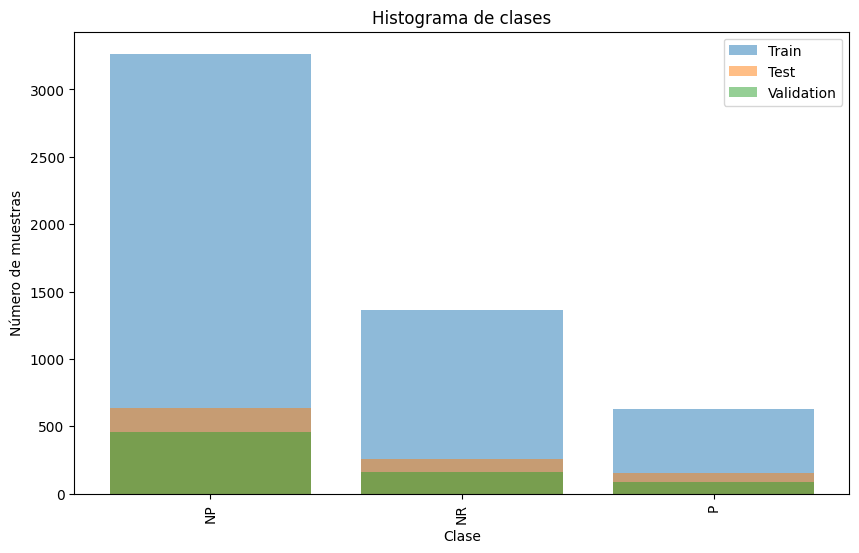

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el dataset a un DataFrame de pandas
df_train = pd.DataFrame(dict_homomex['train'])
df_test = pd.DataFrame(dict_homomex['test'])
df_val = pd.DataFrame(dict_homomex['validation'])

# Concatenar los dataframes de train, test y validation
df_concat = pd.concat([df_train, df_test, df_val])

# Contar las ocurrencias de cada clase en cada conjunto
train_class_counts = df_train['label'].value_counts()
test_class_counts = df_test['label'].value_counts()
val_class_counts = df_val['label'].value_counts()

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.index, train_class_counts.values, alpha=0.5, label='Train')
plt.bar(test_class_counts.index, test_class_counts.values, alpha=0.5, label='Test')
plt.bar(val_class_counts.index, val_class_counts.values, alpha=0.5, label='Validation')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [ ]:
import numpy as np
# Obtener etiquetas con formato de string

dict_homomex2 = load_dataset("csv", data_files=data_files) # borrar
all_labels_str = dict_homomex2['train']['label'] # borrar
STR_LABELS = np.unique(all_labels_str)
STR_LABELS

array(['NP', 'NR', 'P'], dtype='<U2')

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Obtener las etiquetas
labels = dict_homomex['train']['label']

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Codificar las etiquetas
encoded_labels = label_encoder.fit_transform(labels)

# Reemplazar las etiquetas originales en el dataset con las etiquetas codificadas
encoded_dataset = dict_homomex.map(lambda example: {'label': label_encoder.transform([example['label']])[0]}, remove_columns=['label'])

dict_homomex = encoded_dataset

# Imprimir el dataset actualizado
#encoded_dataset['train']['label']

print( np.unique(dict_homomex['train']['label']) )
print( np.unique(encoded_dataset['train']['label']) ) # Verificar que las etiquetas estén codificadas

Map:   0%|          | 0/5250 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

[0 1 2]
[0 1 2]


In [ ]:
# # ----------------------------------------------------------------------------------------------------------------
# # Sustituir el split test de new_dic_homomex, por el split auxiliar de test.


new_dic_homomex = dict_homomex

Tokenizar

In [ ]:
# --------------------------------------------------------------------------------------------
# Cargar el tokenizador que corresponde al modelo que estamos utilizando, en este caso: BERT.
# --------------------------------------------------------------------------------------------

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# ------------------------------------------------------
# Conocer tamaño máximo de tokens en el split de train
# ------------------------------------------------------

MAX_LENGTH= max([len(tokenizer(text).input_ids) for text in new_dic_homomex['train']['text']])
print("Tamaño máximo de tokens:", MAX_LENGTH)

Tamaño máximo de tokens: 314


In [ ]:
# ---------------------------------------------------------------------------
# Definir una función que permite tokenizar por lotes (batch tokenization)
# ---------------------------------------------------------------------------

def tokenize_function( dataset_split ):
    return tokenizer( dataset_split["text"], padding="max_length", max_length=MAX_LENGTH )

In [ ]:
# ---------------------------------------------------------------------------------------------------------------
# Tokenizar el dataset. El método map permite aplicar la función anterior (tokenize_function) a todos los splits.
# ---------------------------------------------------------------------------------------------------------------

encoded_data = new_dic_homomex.map( tokenize_function, batched=True )
#encoded_data['train']['label']

Map:   0%|          | 0/5250 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [ ]:
[encoded_data['train']['label'][i] for i in range(10)]

[0, 0, 0, 0, 1, 0, 1, 2, 2, 0]

In [ ]:
# -------------------------------------------------------
# Comprobar que todos los textos tienen el mismo tamaño
# -------------------------------------------------------

import random
for i in range(10):
    index = random.randint( 0, len(encoded_data) )
    print( 'text:', index, ' len:', len(encoded_data['train'][index]['input_ids']) )

text: 1  len: 314
text: 2  len: 314
text: 1  len: 314
text: 2  len: 314
text: 1  len: 314
text: 3  len: 314
text: 2  len: 314
text: 1  len: 314
text: 2  len: 314
text: 3  len: 314


Cargar modelo BETO y hacer fine-tuning.

In [ ]:
# -------------------------------------------------------------------------
# Obtener las etiquetas y el número de etiquetas en el dataset de training
# -------------------------------------------------------------------------

import numpy as np

all_labels = new_dic_homomex['train']['label']
LABELS = np.unique(all_labels)
NUM_LABELS = len(LABELS)

print( 'LABELS:', LABELS, 'num_labels:', NUM_LABELS )

LABELS: [0 1 2] num_labels: 3


In [ ]:
# ------------------------------------------------------------------------------------
# Cargar modelo pre-entrenado al que le haremos fine-tuning, en este caso, BETO.
# ------------------------------------------------------------------------------------

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=NUM_LABELS)

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# --------------------------------------------------------------------------------------
# Crear objeto de la clase TrainingArguments, que contiene hiperparámetros por defecto.
# --------------------------------------------------------------------------------------

from transformers import TrainingArguments
args = TrainingArguments(output_dir="./outputs")

In [ ]:
# ---------------------------------
# Ajuste manual de hiperparámetros
# ---------------------------------

args.evaluation_strategy="epoch"

args.per_device_train_batch_size = 32
args.per_device_eval_batch_size = 32
args.learning_rate=5e-5

#args

In [ ]:
# -------------------------------------------------------------------------------------------------------
# Definir conjunto de métricas que se utilizarán para evaluar el modelo sobre el conjunto de validación.
# -------------------------------------------------------------------------------------------------------

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):

    y_true = pred.label_ids                 # son las labels reales
    y_pred = pred.predictions.argmax(-1)    # son las predicciones


    acc = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# ---------------------------------------------------------------------
# Preparación para el entrenamiento: crear objeto de la clase Trainer
# ---------------------------------------------------------------------

from transformers import Trainer

trainer = Trainer(
    model = model,                              # modelo que será ajustado
    train_dataset = encoded_data['train'],      # conjunto training
    eval_dataset = encoded_data['validation'],  # conjunto de validación

    args = args,                                # hiperparámetros
    compute_metrics=compute_metrics,            # función para computar las métricas
)

In [ ]:
#encoded_data['train'][0]

In [ ]:
# ------------------
# Entrenar modelo
# ------------------

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.398737,0.852857,0.754830,0.855251,0.720106
2,No log,0.386792,0.860000,0.796428,0.794382,0.799401
3,No log,0.479661,0.857143,0.788260,0.800810,0.780621


TrainOutput(global_step=495, training_loss=0.29007679332386366, metrics={'train_runtime': 824.7979, 'train_samples_per_second': 19.096, 'train_steps_per_second': 0.6, 'total_flos': 2541459780027000.0, 'train_loss': 0.29007679332386366, 'epoch': 3.0})

In [ ]:
# ------------------
# Evaluar modelo
# ------------------

trainer.evaluate()

{'eval_loss': 0.47966089844703674,
 'eval_accuracy': 0.8571428571428571,
 'eval_f1': 0.7882595511720333,
 'eval_precision': 0.8008103008103008,
 'eval_recall': 0.7806211097481031,
 'eval_runtime': 12.9233,
 'eval_samples_per_second': 54.166,
 'eval_steps_per_second': 1.702,
 'epoch': 3.0}

In [ ]:
def get_prediction(text):
    # prepara el texto, aplicamos la misma tokenización que la utilizada en el training
    inputs = tokenizer(text, padding="max_length", max_length=MAX_LENGTH, truncation= True, return_tensors="pt").to("cuda")

    # aplicamos el modelo
    pred = model(**inputs).logits

    # obtenemos la probabilidad para cada clase
    probs = pred.softmax(1)
    # devolvemos la mayor
    return probs.argmax().item()

In [ ]:
y_pred=[get_prediction(text) for text in new_dic_homomex['test']['text']]
y_true = new_dic_homomex['test']['label']

In [ ]:
STR_LABELS

array(['NP', 'NR', 'P'], dtype='<U2')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=STR_LABELS))

              precision    recall  f1-score   support

          NP       0.90      0.92      0.91       639
          NR       0.87      0.90      0.88       259
           P       0.73      0.60      0.66       152

    accuracy                           0.87      1050
   macro avg       0.83      0.81      0.82      1050
weighted avg       0.87      0.87      0.87      1050



matriz de confusion

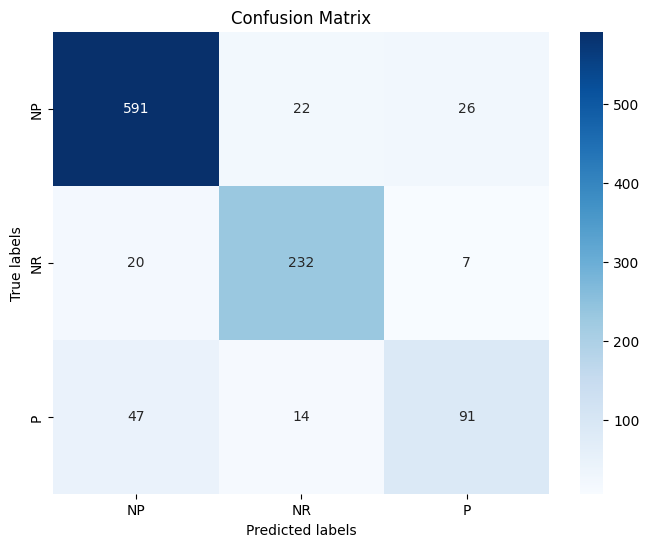

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=STR_LABELS, yticklabels=STR_LABELS)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Save model

In [ ]:
from huggingface_hub.hf_api import HfFolder

HfFolder.save_token('')

In [ ]:
model.push_to_hub('jhovany/Beto_Clasificar_Tweets_Mexicanos_Homomex2024')

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jhovany/Beto_Clasificar_Tweets_Mexicanos_Homomex2024/commit/12fb6bbaac9391fc60a911eff7298ca5661a3d31', commit_message='Upload BertForSequenceClassification', commit_description='', oid='12fb6bbaac9391fc60a911eff7298ca5661a3d31', pr_url=None, pr_revision=None, pr_num=None)